# Trabajo práctico Planificación y Gestión de Políticas de Desarrollo 

Este notebook contiene parte del procesamiento realizado en los datos del TP final de la materia Planificación y Gestión de Políticas de Desarrollo del doctorado en Desarrollo Económico de la Universidad de Quilmes. 
El mismo aborda la evaluación de impacto a partir de datos brindados por el cuerpo docente y se realiza un análisis de la base de datos y luego diferentes métodos para estimar el impacto de un programa asociado a la salud. El objetivo es reducir el gasto en salud de los hogares tratados.

Los métodos utilizados son _before and after_ , _with and without_ y diferencias en diferencias utilizando tanto test de medias (t-test) como regresiones lineales simples y multivariadas.
   

## Tabla de contenidos 

* [Análisis de la base de datos](#db-analysis)
* [With and without](#with_and_without)
* [Before and after](#before_and_after)
* [Diferencias en diferencias](#DD)
* [Referencias](#references)

In [1]:
%matplotlib notebook 
%matplotlib notebook 
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np 
import statsmodels.api as sm
sns.set_style("whitegrid")


def ttest(control,treatment):
    t, p = stats.ttest_ind(control, treatment)  
    diff = control-treatment
    print('Muestras de tratamiento: ', len(control))
    print('Muestras de control: ', len(treatment))
    print('mean1: {} | mean2: {} | meandiff: {}'.format(round(control.mean(),4), round(treatment.mean(),4), 
                                                        round(control.mean()- treatment.mean(),4) ))
    print('std1: {} | std2: {} '.format(round(control.std(),4), round(treatment.std(),4)))
    
    s = None
    if abs(t)>1.96:
        s = 'Es estadísticamente significativo'
    else: 
        s = 'NO es estadísticamente significativo'
    print("t = " + str(round(t,4)), '. ',s)
    print("p = " + str(round(p, 4)))
    
def hist_plot(control, treatment, show_means = True, xlabel='Gasto en salud (US$)', ylabel='Frecuencia'):
    #probar con distribución de kernel (porque quedan normalizadas y mejora la visualización)
    fontsize = 14
    plt.figure() #figsize=(7,5))
    plt.hist(control,histtype='step', linewidth=2, label='Control', bins=50, density=True)
    plt.hist(treatment, histtype='step', linewidth=2, label='Tratamiento', bins=50, density=True)
    if show_means:
        plt.axvline(control.mean(), color='blue', linestyle='--', alpha=0.5)
        plt.axvline(treatment.mean(), color='red', linestyle='--', alpha=0.5)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.legend()
    plt.show()

# Análisis de la base de datos <a class="anchor" id="db-analysis"></a>
En primer lugar veremos los indicadores estadísticos 

Estadísticas de los datos no binarios


,count,mean,std,min,25%,50%,75%,max
indice_pobreza,15862.0,56.784275,10.654303,20.479134,49.652241,56.414219,62.828438,98.763527
gasto_salud,15862.0,16.999828,9.212503,0.000000,11.619595,16.067859,21.191925,116.830643
edad_jefe,15862.0,46.664806,15.341037,14.000000,34.000000,45.000000,58.000000,88.000000
edad_conyuge,15862.0,40.610958,12.906209,14.000000,31.000000,41.000000,48.000000,88.000000
educacion_jefe,15862.0,2.855169,2.772236,0.000000,0.000000,2.000000,4.000000,16.000000
educacion_conyuge,15862.0,2.615149,2.540237,0.000000,0.000000,2.000000,4.000000,17.000000
tamano_hogar,15862.0,5.177468,2.192136,1.000000,4.000000,5.000000,7.000000,13.000000
dist_hospital,15862.0,105.413874,42.007661,9.465392,72.804218,113.556497,140.630494,170.457647
land,15862.0,2.076157,3.124752,0.000000,0.000000,1.000000,3.000000,23.000000




Estadísticas de los datos binarios


,mean
localidad_tratada,0.496596
localidad_promocionada,0.511033
eligible,0.567205
inscripto,0.297062
inscripto_aleatorio,0.291262
ronda,0.496722
jefe_mujer,0.097340
lengua,0.356449
piso_tierra,0.605409
bano,0.616694


<IPython.core.display.Javascript object>


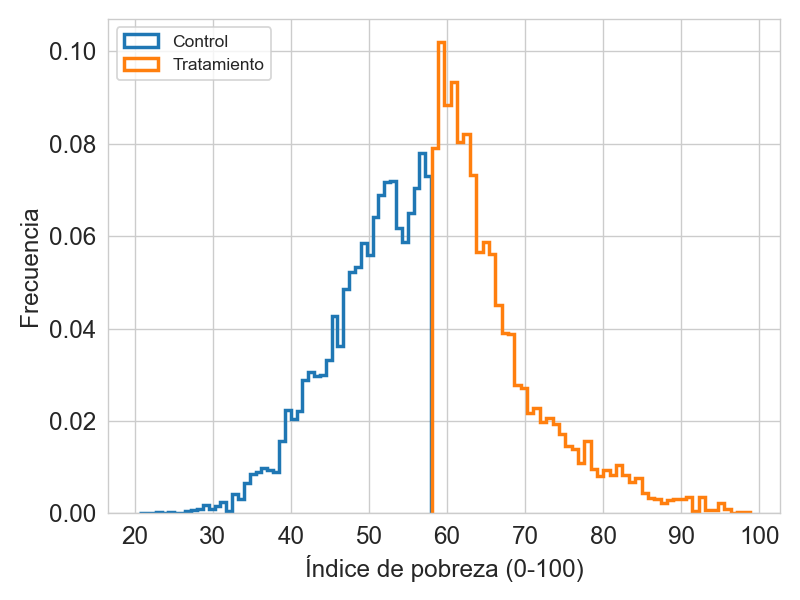

Cantidad de muestras totales:  15862
Cantidad de localidades:  200
Cantidad de localidades tratadas:  100
Cantidad total de hogares:  9525
Cantidad total de hogares elegibles:  5415
Cantidad total de hogares inscriptos:  2852
Cantidad total de hogares por fuera del programa (no elegibles):  4110


In [2]:
data = pandas.read_stata('database.dta')
data['id_hogar'] = data['id_hogar'].astype(int)
data['id_localidad'] = data['id_localidad'].astype(int)
data['ronda'] = data['ronda'].astype(int)
data['id_loc_hog'] = data['id_localidad'].astype(str) + '-' + data['id_hogar'].astype(str)
# data['gasto_salud_log'] = np.log(data.gasto_salud+1) 
# data['indice_pobreza_log'] = np.log(data.indice_pobreza+1) 

data = data.sort_values(by=['id_loc_hog', 'ronda'])

nonbinary = ['indice_pobreza', 'gasto_salud', 'edad_jefe', 'edad_conyuge', 'educacion_jefe',
             'educacion_conyuge', 'tamano_hogar', 'dist_hospital', 'land']

binary = ['localidad_tratada', 'localidad_promocionada', 'eligible', 'inscripto', 
          'inscripto_aleatorio', 'ronda', 'jefe_mujer', 'lengua', 
          'piso_tierra', 'bano', 'hospital']

    
print('Estadísticas de los datos no binarios')
display(data[nonbinary].describe().T)

print()
print()

print('Estadísticas de los datos binarios')
display(data[binary].describe().loc[['mean']].T)


a = data.indice_pobreza[(data.eligible == 1)]
b = data.indice_pobreza[(data.eligible == 0)]
                        
hist_plot(a, b, show_means=False, xlabel='Índice de pobreza (0-100)')

print('Cantidad de muestras totales: ', len(data))
print('Cantidad de localidades: ', len(set(data.id_localidad)))
print('Cantidad de localidades tratadas: ', len(set(data.id_localidad[data.localidad_tratada==1])))

print('Cantidad total de hogares: ', len(set(data.id_hogar)))
print('Cantidad total de hogares elegibles: ', len(set(data.id_hogar[data.eligible==1])))
print('Cantidad total de hogares inscriptos: ', len(set(data.id_hogar[data.inscripto==1])))
print('Cantidad total de hogares por fuera del programa (no elegibles): ', len(set(data.id_hogar[data.eligible==0])))


#### Criterio de separación entre control y tratamiento

A partir de la exploración y el análisis de los datos se puede concluir que se separaron las poblaciones para control y tratamiento en función del **índice de pobreza** y la separación se hace en 58

# With and without 
<a class="anchor" id="with_and_without"></a>
<img src="images/with_without.png" alt="Drawing" style="width: 500px;"/>
<div style="text-align: center"> Esquema de with and without. Extraído de [Shahidur, 2010]  </div>

**With and without**
$$Y_4 - Y_3$$

**Comparación "correcta"**
$$Y_4 - Y_2$$

&emsp;

<!--**Validez externa:** *una muestra de potenciales participantes se seleccionan de una población relevante.* En nuestro caso, la variable **localidad_promocionada** nos permitirá seleccionar aleatoriamente a nuestros potenciales hogares relevantes.

&nbsp;

 **Validez interna:** los individuos de la muestra son asignados de manera aleatoria a un grupo de control y a otra de tratamiento. La variable **inscripto_aleatorio** indica que se ese conjunto de personas se separó de manera aleatoria, dándole validez interna. 

&emsp;

$H_0$: No hay diferencia entre las medias de la población tratada y la de control

$H_a$: Hay diferencia  -->




### En función de si fueron inscriptos

La variable sobre la cual buscamos ver la diferencia es el **gasto en salud**. Para hacer una primera comparación de tipo *With and without*, debemos estudiar a la gente que se le aplicó el programa vs. gente a la cual no fue aplicado el programa. Para tomar la misma ventana temporal, se utiliza la **ronda** de seguimiento. 

<IPython.core.display.Javascript object>


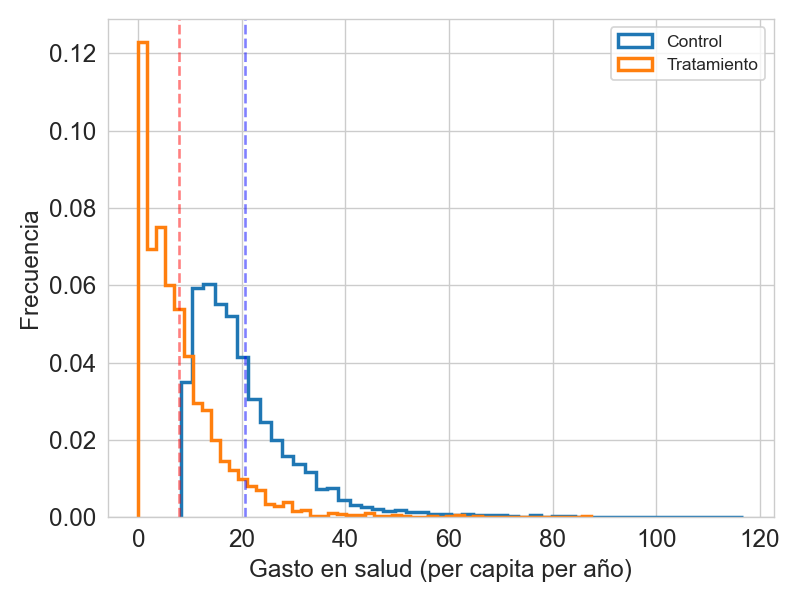

Muestras de tratamiento:  5540
Muestras de control:  2339
mean1: 20.631200790405273 | mean2: 7.798600196838379 | meandiff: 12.832599639892578
std1: 11.05370044708252 | std2: 7.990600109100342 
t = 50.819 .  Es estadísticamente significativo
p = 0.0


In [3]:
condition = (data.ronda== 1) 

control = data.gasto_salud[condition  & (data.inscripto==0)]
treatment = data.gasto_salud[condition  & (data.inscripto==1)]

xlabel = 'Gasto en salud (per capita per año)'
ylabel = 'Frecuencia'

hist_plot(control, treatment, xlabel=xlabel, ylabel=ylabel)

ttest(control, treatment)

### Aleatorio (extra)
Se seleccionaron las localidades elegidas de manera aleatoria y luego la selección aleatoria de inscriptos al programa de manera aleatoria. Se tomaron los participantes de la segunda ronda, ya que es más correcto comparar sobre la misma ventana temporal


<!-- &emsp;
#### Duda

<img src="images/duda.png" alt="Drawing" style="width: 800px;"/>

En mi caso, 

$$ATE<TOT$$

¿Este resultado sugiere que estoy planteando mal el problema?
 -->

<IPython.core.display.Javascript object>


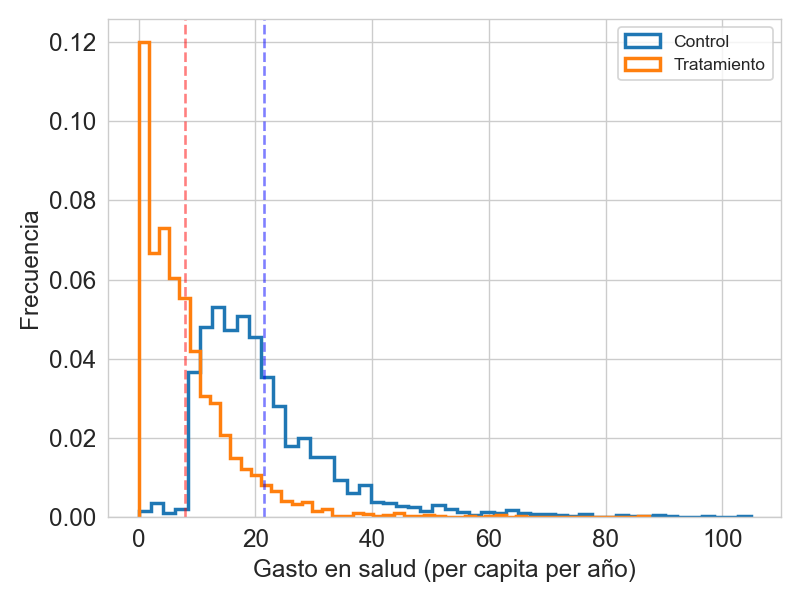

Muestras de tratamiento:  2044
Muestras de control:  1967
mean1: 21.505300521850586 | mean2: 8.00790023803711 | meandiff: 13.497400283813477
std1: 12.069499969482422 | std2: 8.20829963684082 
t = 41.2587 .  Es estadísticamente significativo
p = 0.0


In [4]:
condition = (data.localidad_promocionada == 1)& (data.ronda== 1) 

control = data.gasto_salud[condition  & (data.inscripto_aleatorio==0)]
treatment = data.gasto_salud[condition  & (data.inscripto_aleatorio==1)]

xlabel = 'Gasto en salud (per capita per año)'
ylabel = 'Frecuencia'

hist_plot(control, treatment, xlabel=xlabel, ylabel=ylabel)

ttest(control, treatment)

### Teniendo en cuenta algunas características de la población (no aleatorio)
<!-- ~Se busca hacer un análisis _with and without_ comparando los hogares que se encontraban en localidades que fueron seleccionadas para ser tratadas y que eran elegibles.~ 
 -->
Para distinguir la población de tratamiento de la de control se eligió la variable **inscripto** ya que es la que determina si efectivamente se aplicó el programa o no a los hogares que estaban en condiciones de recibirlo. Es importante destacar que la comparación debe ser sobre la misma ventana temporal, por lo que utilizaremos la **segunda ronda**. Escrito en pseudo código:


    if elegible==1 & ronda==1
        en función de inscripto
    comparar gasto_salud

<!-- ~Se aplica la función logarítimica sobre los gastos de salud para visualizar las elasticidades de cada variable.~ -->




<IPython.core.display.Javascript object>


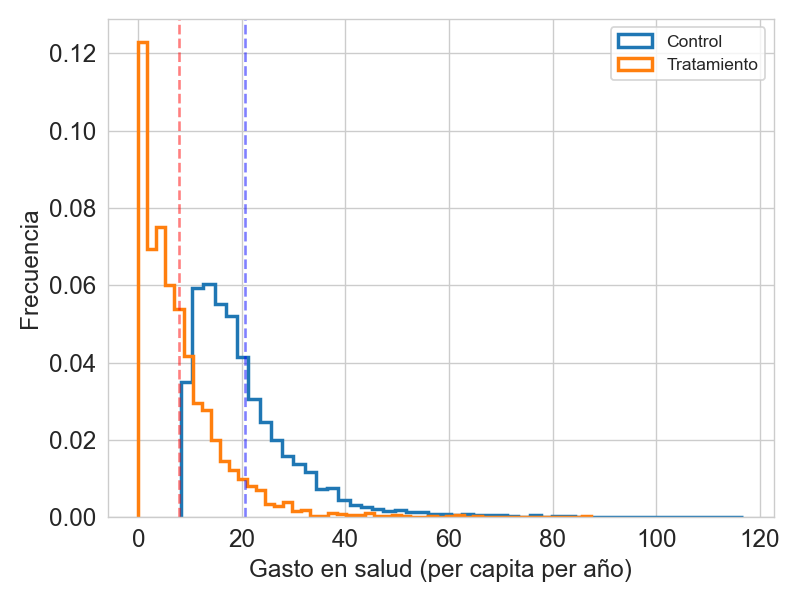

Muestras de tratamiento:  5540
Muestras de control:  2339
mean1: 20.631200790405273 | mean2: 7.798600196838379 | meandiff: 12.832599639892578
std1: 11.05370044708252 | std2: 7.990600109100342 
t = 50.819 .  Es estadísticamente significativo
p = 0.0


In [5]:
# condition = (data.eligible == 1)& (data.ronda== 1) 
'''El especialista menciona  que todos los hogares son elegibles ya que 
tienen características muy similares pero que hay que compararlo dos años después (ronda==1).
Esto sería el punto e'''
condition = (data.ronda== 1) 

control = data.gasto_salud[condition  & (data.inscripto==0)]
treatment = data.gasto_salud[condition  & (data.inscripto==1)]

xlabel = 'Gasto en salud (per capita per año)'
ylabel = 'Frecuencia'

hist_plot(control, treatment, xlabel=xlabel, ylabel=ylabel)

ttest(control, treatment)

# Before and after  <a class="anchor" id="before_and_after"></a>


<img src="images/before_after.png" alt="Drawing" style="width: 500px;"/>
<div style="text-align: center"> Esquema de before and after. Extraído de [Shahidur, 2010]  </div>

## Before and after "puro"

<!-- #### Cosulta
¿Deberíamos comparar a los que están efectivamente inscriptos únicamente? Yo creería que sí porqeu son sobre los que podemos ver la evolución efectiva -->

<IPython.core.display.Javascript object>


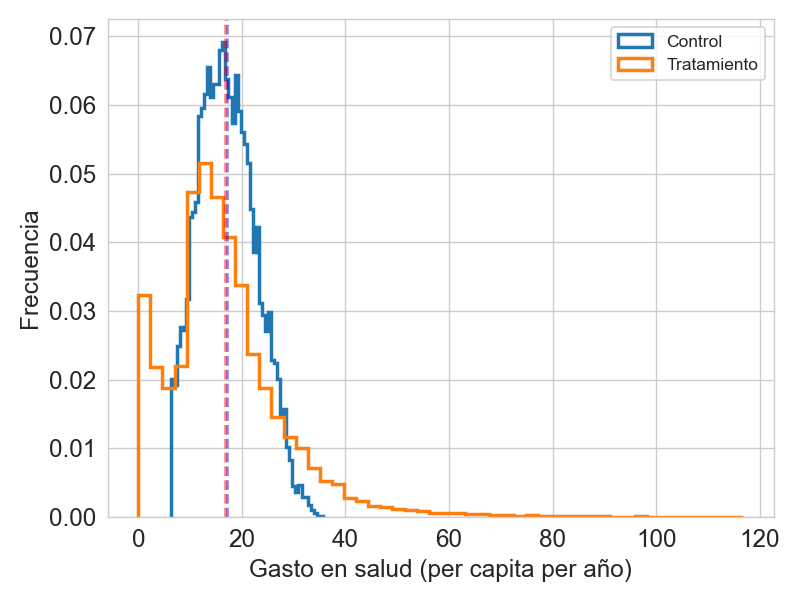

Muestras de tratamiento:  7983
Muestras de control:  7879
mean1: 17.17569923400879 | mean2: 16.821699142456055 | meandiff: 0.3540000021457672
std1: 5.582399845123291 | std2: 11.799799919128418 
t = 2.4202 .  Es estadísticamente significativo
p = 0.0155


In [20]:
# condition = (data.inscripto == 1)

control = data.gasto_salud[(data.ronda==0)]
treatment = data.gasto_salud[(data.ronda==1)]

xlabel = 'Gasto en salud (per capita per año)'
ylabel = 'Frecuencia'

hist_plot(control, treatment, xlabel=xlabel, ylabel=ylabel)

ttest(control, treatment)

## Before and after aleatorio

<IPython.core.display.Javascript object>


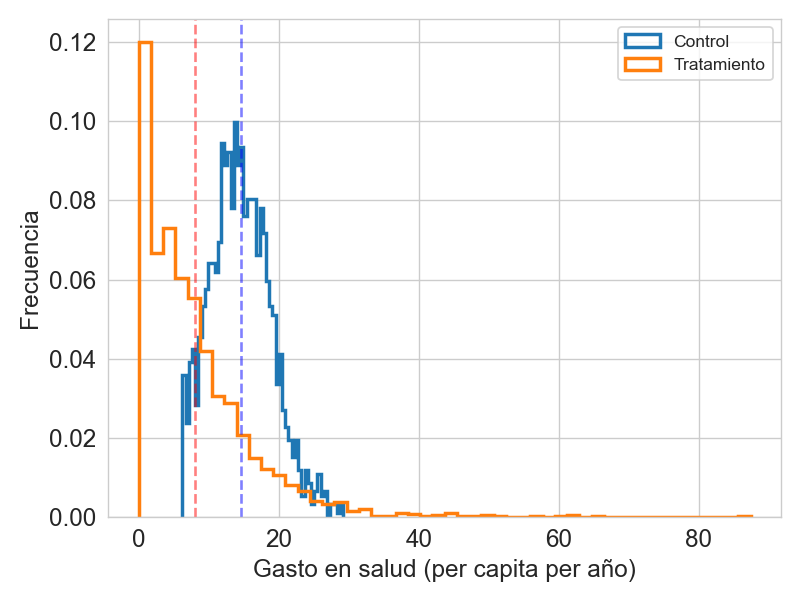

Muestras de tratamiento:  2007
Muestras de control:  1967
mean1: 14.560199737548828 | mean2: 8.00790023803711 | meandiff: 6.552299976348877
std1: 4.307799816131592 | std2: 8.20829963684082 
t = 31.5963 .  Es estadísticamente significativo
p = 0.0


In [7]:
condition = (data.localidad_promocionada == 1)& (data.inscripto_aleatorio== 1) 

control = data.gasto_salud[condition  & (data.ronda==0)]
treatment = data.gasto_salud[condition  & (data.ronda==1)]

xlabel = 'Gasto en salud (per capita per año)'
ylabel = 'Frecuencia'

hist_plot(control, treatment, xlabel=xlabel, ylabel=ylabel)

ttest(control, treatment)

### No aleatorio

<IPython.core.display.Javascript object>


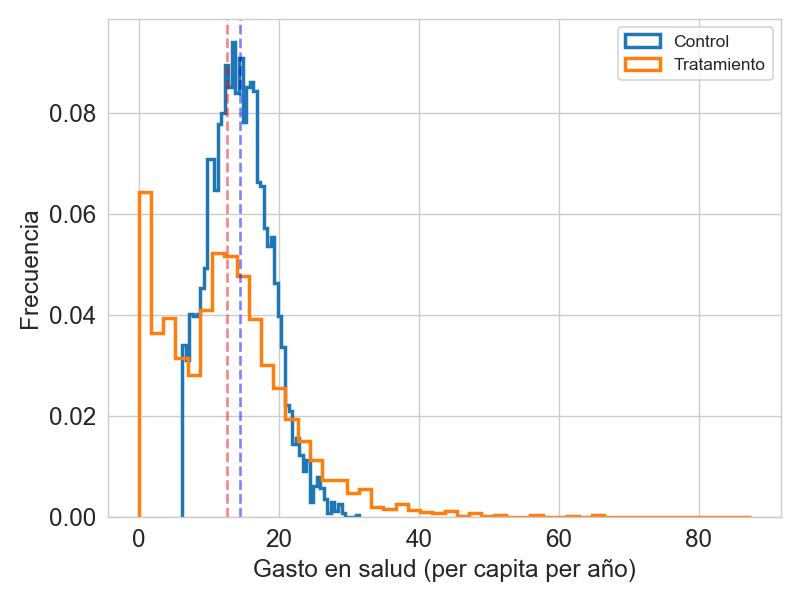

Muestras de tratamiento:  4534
Muestras de control:  4463
mean1: 14.505800247192383 | mean2: 12.591099739074707 | meandiff: 1.9148000478744507
std1: 4.308700084686279 | std2: 9.131799697875977 
t = 12.7506 .  Es estadísticamente significativo
p = 0.0


In [8]:
condition = (data.eligible==1)
control = data.gasto_salud[(data.ronda==0) & condition]
treatment = data.gasto_salud[(data.ronda==1) & condition]

xlabel = 'Gasto en salud (per capita per año)'
ylabel = 'Frecuencia'
hist_plot(control, treatment, xlabel=xlabel, ylabel=ylabel)

ttest(control, treatment)
                         

<IPython.core.display.Javascript object>


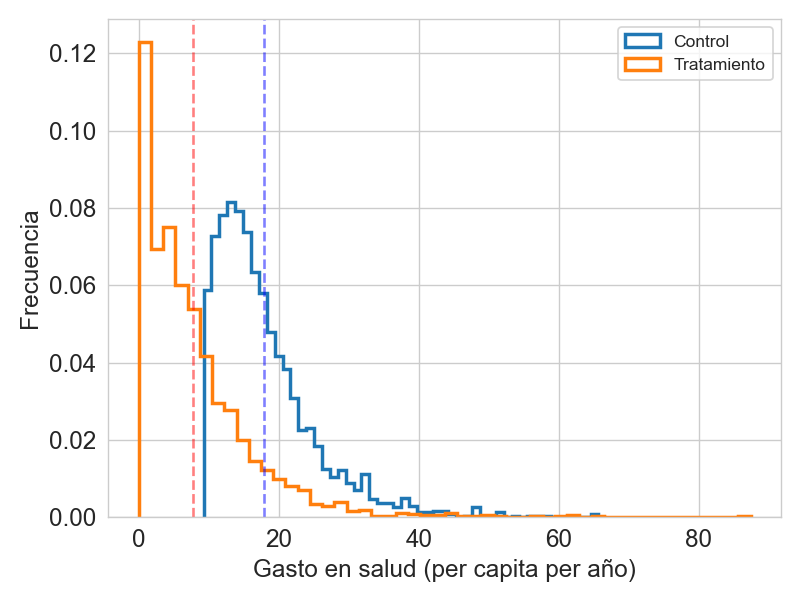

In [9]:
condition = (data.ronda==1) & (data.eligible==1)

control = data.gasto_salud[(data.inscripto == 0) & condition]
treatment = data.gasto_salud[(data.inscripto == 1) & condition]

xlabel = 'Gasto en salud (per capita per año)'
ylabel = 'Frecuencia'
hist_plot(control, treatment, xlabel=xlabel, ylabel=ylabel)


### III. Construcción válida del contrafactual

_Vamos a suponer que la elección de las localidades y los de los hogares que participan en el programa se realiza de forma aleatoria_

Cantidad de muestras control:  2124
Cantidad de muestras tratamiento:  2339
Variable 	 media C 	 media T 	 Diferencia 	 t-valor
localidad_tratada 	 0.0 	 1.0 	 -1.0 	 -inf
localidad_promocionada 	 0.16478343 	 0.85763144 	 -0.692848 	 -64.22442679229763
eligible 	 1.0 	 1.0 	 0.0 	 nan
inscripto 	 0.0 	 1.0 	 -1.0 	 -inf
inscripto_aleatorio 	 0.0 	 0.9816161 	 -0.9816161 	 -336.6911161488518
ronda 	 1.0 	 1.0 	 0.0 	 nan
jefe_mujer 	 0.074387945 	 0.07652843 	 -0.0021404848 	 -0.2702368831015224
lengua 	 0.43032014 	 0.44335186 	 -0.013031721 	 -0.8764137546282121
piso_tierra 	 0.7410546139359698 	 0.7268063274903805 	 0.014248286445589287 	 1.0752194682252754
bano 	 0.5583804143126178 	 0.5805899957246686 	 -0.02220958141205087 	 -1.4967933291371154
hospital 	 0.048964217 	 0.050021376 	 -0.0010571592 	 -0.16254314968208725
indice_pobreza 	 49.747154 	 49.398296 	 0.34885788 	 1.937567083901918
gasto_salud 	 17.868637 	 7.7985845 	 10.070053 	 44.076288403769325
edad_jefe 	 43.228813 

<IPython.core.display.Javascript object>


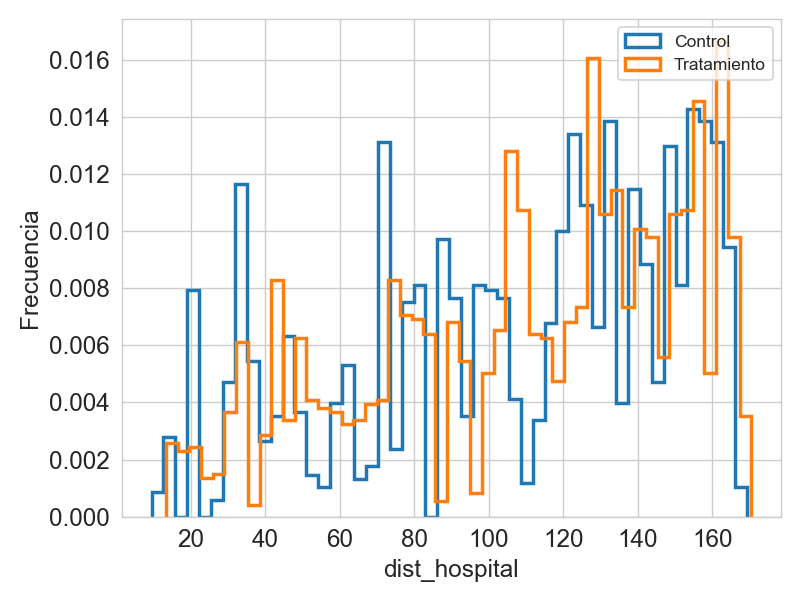

In [10]:
condition = (data.ronda==1) & (data.eligible==1)# & (data.educacion_jefe<6)

control = data[(data.inscripto == 0) & condition]
treatment = data[(data.inscripto == 1) & condition]
print('Cantidad de muestras control: ', len(control))
print('Cantidad de muestras tratamiento: ', len(treatment))

print('Variable', '\t', 'media C','\t', 'media T', 
          '\t', 'Diferencia','\t', 't-valor')
tutti = binary+nonbinary
for col in tutti:
    t, p = stats.ttest_ind(control[col], treatment[col])
    print(col, '\t', control[col].mean(),'\t', treatment[col].mean(), 
          '\t', control[col].mean()- treatment[col].mean(),'\t', t)

# var = 'educacion_jefe'
var = 'dist_hospital'
hist_plot(control[var], treatment[var], xlabel=var, show_means=False)

#### Estimar el contrafactual como los gastos promedio en salud de los hogares elegibles en los pueblos del grupo de comparación.

In [11]:
condition = (data.eligible==1) & (data.ronda==0) 

contrafactual = data[condition]
# tratamiento =  data[(data.localidad_tratada==1) & condition]
print(contrafactual.gasto_salud.mean())
# print(tratamiento.gasto_salud.mean())

14.505848


#### Calcule el impacto del programa como la diferencia entre los gastos promedio en salud de los hogares en los pueblos de tratamiento y de control asignados de forma aleatoria en el período de seguimiento

In [12]:
condition = (data.localidad_promocionada==1) & (data.inscripto_aleatorio==1) 

control = data[condition & data.ronda==0]
tratamiento=data[condition& data.ronda==1]

print('Control: ', control.gasto_salud.mean())
print('Tratamiento: ', tratamiento.gasto_salud.mean())


Control:  18.27274
Tratamiento:  8.007906


## Diferencias en diferencias ($DD$)  <a class="anchor" id="DD"></a>


El estimador $DD$ permite la **heterogeneidad no observada** que puede conducir a un sesgo de selección. El DD asume que esta heterogeneidad es **invariante en el tiempo**, por lo que ese sesgo se elimina a partir de la diferencia. Los cambios en el resultado para los no participantes revelan los cambios en el resultado contrafactual.


Este método utiliza **datos de panel**, es decir, observaciones del individuo $i$ en dos momentos diferentes de tiempo. Es por este motivo que se opta por filtrar los hogares que participan en una sola ronda y se buscará comparar los hogares que participaron a lo largo de todo el programa. Esto traerá dos consecuencias:


- Se perderán muestras, por lo que se deberá analizar qué porcentaje se pierde al realizar este filtrado
- Se eliminará el sesgo proveniente de la no participación en el programa en su totalidad. Por ejemplo, una persona que participa en la segunda ronda, podría tener características muy disimiles en la primera ronda en comparación con el resto de los hogares que son elegibles para participar

La cantidad total de muestras que cumplen se participan de las dos rondas es 12674,lo cual representa un 80% de la cantidad total de muestras
inscripto  ronda
0.0        0        14.586147
           1        17.938274
1.0        0        14.389899
           1         7.638787
Name: gasto_salud, dtype: float32

Impacto del programa
a-b:  -6.7511125
c-d:  3.352127
a-c:  -10.299488
b-d -0.19624805
Diff:  -10.103239


<IPython.core.display.Javascript object>


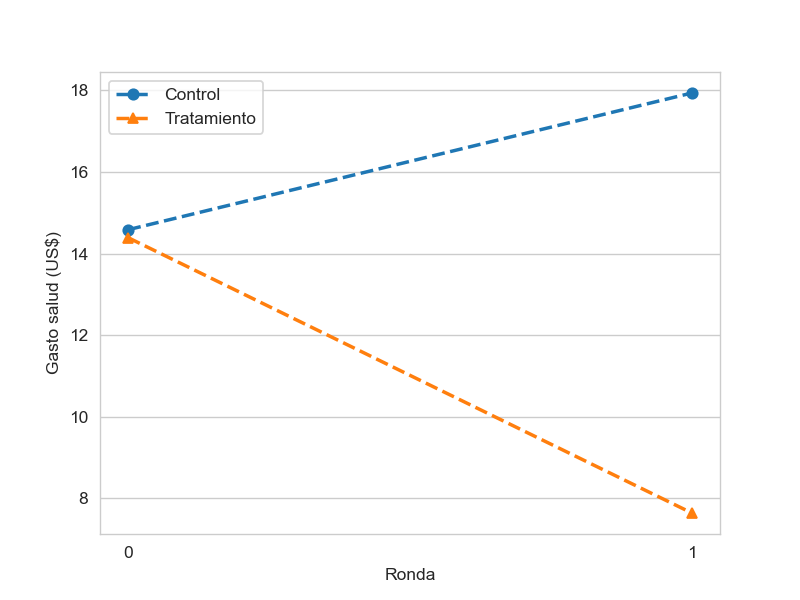

In [13]:
data = data.sort_values(by=['id_loc_hog', 'ronda'])

two_round = data.duplicated(subset=['id_loc_hog'], keep=False)

two_round_data = data[two_round]
one_round_data = data[~(two_round)]

print('La cantidad total de muestras que cumplen se participan de las dos rondas es {},' 
      'lo cual representa un {}% de la cantidad total de muestras'.format(len(two_round_data),
                                                                         round(len(two_round_data)/len(data)*100)))

condition = (two_round_data.eligible==1)
two_round_data = two_round_data[condition]
diff_data = two_round_data.gasto_salud[(two_round_data.ronda==1)].values - \
            two_round_data.gasto_salud[(two_round_data.ronda==0)].values

k = two_round_data.groupby(by=['inscripto', 'ronda']).gasto_salud.mean()
inscripto0_ronda0, inscripto0_ronda1, inscripto1_ronda0, inscripto1_ronda1 = k.values

a_b = inscripto1_ronda1 - inscripto1_ronda0
c_d = inscripto0_ronda1 - inscripto0_ronda0
a_c = inscripto1_ronda1 - inscripto0_ronda1
b_d = inscripto1_ronda0 - inscripto0_ronda0
tot_diff = a_b - c_d

print(k)
print('\nImpacto del programa')
print('a-b: ', a_b)
print('c-d: ', c_d)
print('a-c: ', a_c)
print('b-d', b_d)
print('Diff: ', tot_diff)

# Gráfico comparativo, tomado de [Garganta, 2012]
fig, ax = plt.subplots()
ax.plot(np.array([inscripto0_ronda0, inscripto0_ronda1]), '--o', linewidth=2, label='Control')
ax.plot(np.array([inscripto1_ronda0, inscripto1_ronda1]), '--^', linewidth=2, label='Tratamiento')
ax.set_ylabel('Gasto salud (US$)')
ax.set_xlabel('Ronda')
ax.legend()
plt.grid(axis='x')
plt.xticks([0,1])
plt.show()
# print(k.values)

### Impacto del programa
Como podemos visualizar en la salida del código, la cantidad total de muestras analizadas es $12.674$ que corresponde al $80\%$ de los datos que teníamos. Con este filtrado se trabaja únicamente con hogares que hayan participado a lo largo de todo el programa. 

Los resultados obtenidos se muestran en la siguiente Tabla:

&emsp;

|  || Seguimiento | Línea de base | Diferencia |
| --- || --- | --- | --- |
| Inscriptos || 7.68 | 14.38 | -6.75|
| No-Inscriptos || 17.93 | 14.58 | 3.35|
| Diferencia || -10.3 | -.2 | -10.10 |

&emsp;

A partir de este análisis se puede asegurar que la línea base se mantiene relativamente estable a lo largo del programa y que se logra una diferencia mayor a 10 US$ entre los hogares que participan del programa y los que no participan.

<IPython.core.display.Javascript object>


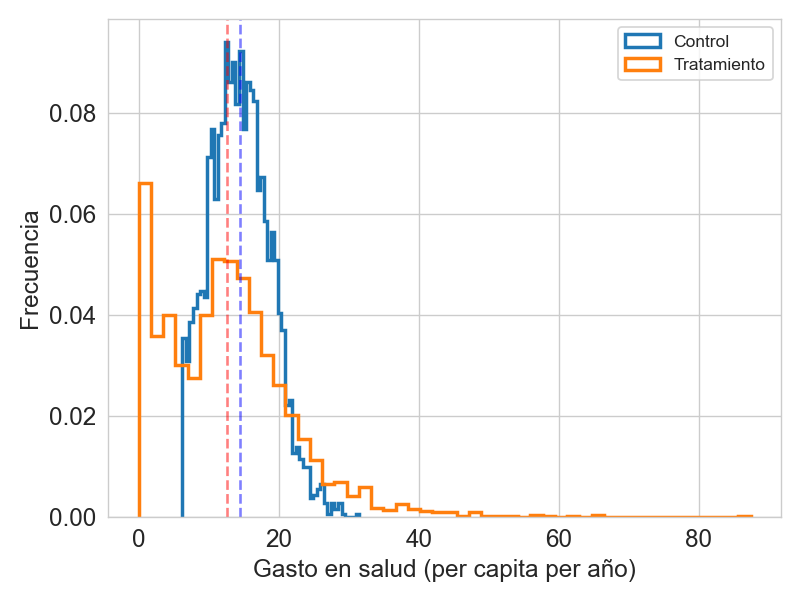

Control media:  14.484244
Tratamiento media:  12.590132


In [14]:
condition = (two_round_data.eligible==1)
control =  two_round_data.gasto_salud[two_round_data.ronda==0 & condition] 
treatment =  two_round_data.gasto_salud[two_round_data.ronda==1 & condition]
hist_plot(control, treatment, xlabel=xlabel, ylabel=ylabel)
print('Control media: ',control.mean())
print('Tratamiento media: ',treatment.mean())
# two_round_data

### Regresión lineal para $DD$

El $DD$ también se puede estimar a partir de una regresión lineal a partir de la siguiente ecuación:

$$
Y_{it} = \alpha + \beta T_{it}t + \rho T_{it} + \gamma t + \epsilon_{ti}
$$

$\beta$: coeficiente que surge de la interacción entre el tratamiento y el tiempo 

Si lo escribiéramos como las esperanzas:

$$
E(Y_1^T - Y_0^T | T_1 = 1) = (\alpha + DD + \rho + \gamma) - (\alpha + \rho)
$$

y

$$
E(Y_1^C - Y_0^C | T_1 = 0) = \alpha + \gamma - \alpha
$$

A partir de estas dos ecuaciones, podemos ver que el término $\alpha$, $\rho$ y $\gamma$ se cancelan permitiendo obtener únicamente el término $\beta$ que lo podemos asociar a $DD$

&nbsp;

#### Implementación para dos variables
Se utiliza la biblioteca **statsmodels** de Python para aplicar una regresión lineal sobre los datos de panel. Si bien los datos analizados son los mismos, el algoritmo que utiliza esta biblioteca difiere del utilizado por Stata. De todas formas, se pueden extraer conclusiones similares ya que los t-valores son estadísticamente significativos en las mismas variables.

Las variables estadísticamente significativas son: 
- inscripto
- jefe_mujer
- tamano_hogar
- land

In [15]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

data = data.sort_values(by=['id_loc_hog', 'ronda'])

two_round = data.duplicated(subset=['id_loc_hog'], keep=False)

two_round_data = data[two_round]
one_round_data = data[~(two_round)]

condition = (two_round_data.inscripto==1)
diff_data = two_round_data.gasto_salud[(two_round_data.ronda==1) & condition].values - \
            two_round_data.gasto_salud[(two_round_data.ronda==0) & condition].values

labels = ['inscripto', 'indice_pobreza', 'edad_jefe', 'edad_conyuge', 'educacion_jefe', 
 'educacion_conyuge', 'jefe_mujer', 'lengua', 'tamano_hogar', 'piso_tierra', 'bano', 
 'land', 'dist_hospital', 'hospital']
y = diff_data
X = two_round_data[(two_round_data.ronda==1) & condition][labels]

X2 = sm.add_constant(X['inscripto'])
est = sm.OLS(y, X2)
est2 = est.fit(use_t=True)
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 03 Mar 2021   Prob (F-statistic):                nan
Time:                        23:08:10   Log-Likelihood:                -6333.3
No. Observations:                1860   AIC:                         1.267e+04
Df Residuals:                    1859   BIC:                         1.267e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
inscripto     -6.7511      0.169    -39.947      0.0

#### Regresión multivariable

In [16]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit(use_t=True)
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     5.658
Date:                Wed, 03 Mar 2021   Prob (F-statistic):           2.96e-10
Time:                        23:08:10   Log-Likelihood:                -6296.9
No. Observations:                1860   AIC:                         1.262e+04
Df Residuals:                    1846   BIC:                         1.270e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
inscripto            -5.3136      1.84

# Referencias

**[Garganta, 2012]** Garganta, S., Gasparini, L. (2012). El impacto de un programa social sobre la informalidad laboral: El caso de la AUH en Argentina, Documento de trabajo, No. 133.

**[Shahidur, 2010]** Khandker, S. R., Koolwal, G. B., & Samad, H. A. (2010). Handbook on Impact Evaluation. THE WORLD BANK Washington, D.C.